# **Модель машинного обучения, предсказывающая отключения электроэнергии на ЛЭП 110 кВ (Часть 2)**


Обеспечение надежного электроснабжения потребителей при условии поставки им качественной электрической энергии является необходимым условием эффективного развития народного хозяйства. Завышенная протяжённость, совместно с износом сетей приводит к тому, что поток отказов в них доходит до 37 год-1 на 100 км, а время восстановления – до 8 ч. Ущербы от недоотпуска электроэнергии составляют от 30 до 300 руб./кВт·ч и более. Влияет протяжённость и состояние сети и на безопасность эксплуатации. С учётом указанных выше и других проблем в электроснабжении сельских потребителей актуальными являются вопросы поиска способов прогнозирования мест, наиболее подверженных к перерывам в электроснабжении.  

**Данные** В наличии имеются подготовленные на раннем этапе данные по отключениям ЛЭП 110 кВ для обучения обучения модели.

**Цель** - разработать модель машинного обучения для прогнозирования возможных отключений электроэнергии на линиях электропередачи на основе  характеристик самих ЛЭП.

**Задачи:**

- Разбиение датасета на обучающую и тестовую выборки
- Кодирование и масштабирование признаков, при необходимости работа с дисбалансом классов
- Выбор и обучение разных моделей машинного обучения на кросс-валидации
- Выбор лучшей модели по метрике ROC-AUC на кросс-валидации
- Оценка качества лучшей модели на тестовой выборке
- Анализ других метрик, построение матрицы ошибок и  изучение важности признаков лучшей модели.
- Выводы

In [1]:
%%capture

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

!pip install phik
import phik
from phik import resources
from phik.binning import bin_data
from phik.report import plot_correlation_matrix
from IPython.display import display, HTML


from imblearn.over_sampling import SMOTENC
from imblearn.pipeline import Pipeline as Pipeline_smote
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve,\
accuracy_score, confusion_matrix, f1_score, average_precision_score, precision_score, recall_score
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.utils.class_weight import compute_class_weight
from sklearn.svm import SVC

!pip install catboost
import catboost as cat
from catboost import CatBoostClassifier, Pool, cv

!pip install lightgbm
import lightgbm
from lightgbm import LGBMClassifier

import warnings
warnings.filterwarnings("ignore")

In [2]:
#!pip list
#pd.__version__
!pip show scikit-learn

Name: scikit-learn
Version: 1.2.2
Summary: A set of python modules for machine learning and data mining
Home-page: http://scikit-learn.org
Author: 
Author-email: 
License: new BSD
Location: /usr/local/lib/python3.10/dist-packages
Requires: joblib, numpy, scipy, threadpoolctl
Required-by: bigframes, fastai, imbalanced-learn, librosa, mlxtend, qudida, sklearn-pandas, yellowbrick


## Загрузка данных

In [3]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [5]:
# Загружаем подготовленный датасет
ML_df_110 = pd.read_excel(open("/content/gdrive/MyDrive/Data_for_ML_ETL_110kV.xlsx", 'rb'), index_col=0)
ML_df_110

,Факт отключения,"Индекс состояния, %","Проводник, тип, сечение","Протяженность воздушных участков, км",Отношение ЛЭП к транзиту,"Переэксплуатация, бр.","ЖБ Опоры, %","Протяженность по лесу, %","Протяженность по населенной местности, %"
0,Да,79,АС-95,13.050,Транзитная,1.171429,0.986667,0.506667,0.106667
2,Да,79,АС-95,13.050,Транзитная,1.200000,0.986667,0.506667,0.106667
4,Нет,79,АС-95,13.050,Транзитная,1.057143,0.986667,0.506667,0.106667
6,Нет,79,АС-95,13.050,Транзитная,1.085714,0.986667,0.506667,0.106667
8,Нет,79,АС-95,13.050,Транзитная,1.114286,0.986667,0.506667,0.106667
...,...,...,...,...,...,...,...,...,...
1740,Нет,88,АС-120,3.176,Не транзитная,0.171429,0.130435,0.579345,0.000000
1741,Нет,88,АС-120,3.176,Не транзитная,0.200000,0.130435,0.579345,0.000000
1742,Нет,88,АС-120,3.176,Не транзитная,0.228571,0.130435,0.579345,0.000000
1743,Нет,88,АС-120,3.176,Не транзитная,0.257143,0.130435,0.579345,0.000000


Выведем гистограммы для категориальных признаков и график плотности распределения для количественных, при этом последние будем строить с ядерной оценкой плотности, в качестве ядра которого воспользуемся Гауссовским ядром.

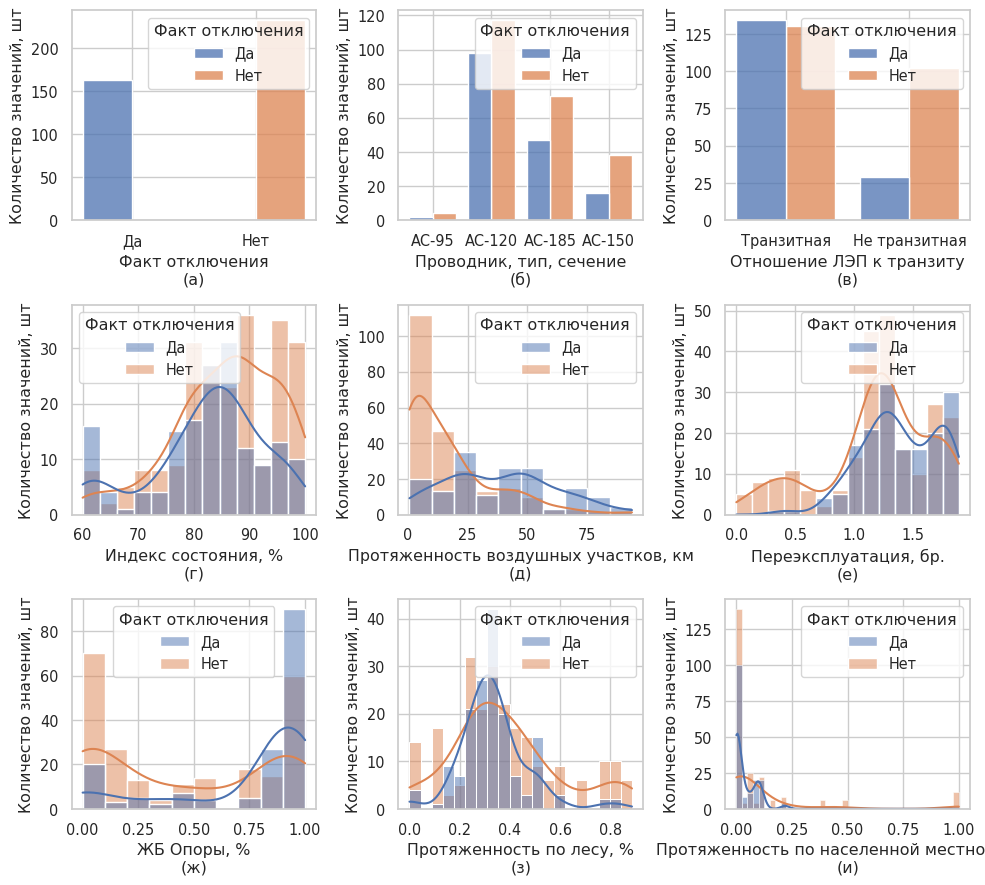

In [6]:
alphabet = ['а','б','в','г','д','е','ж','з', 'и']

pic_box = plt.figure(figsize=(10,9))
sns.set_theme(context='notebook', style='whitegrid', palette='deep', font='sans-serif', font_scale=0.95, color_codes=True, rc=None)

for i in range(len(ML_df_110.select_dtypes(include='object').columns.tolist())):
    pic_box.add_subplot(3,3,i+1)
    sns.histplot(data=ML_df_110,
                 x=ML_df_110.select_dtypes(include='object').columns.tolist()[i],
                 hue='Факт отключения',
                 multiple='dodge',
                 shrink = 0.8,
                 stat='count'
                ).set_xlabel(f'{ML_df_110.select_dtypes(include="object").columns.tolist()[i]}\n({alphabet[i]})')
    plt.ylabel('Количество значений, шт')


for i in range(len(ML_df_110.select_dtypes(include=[np.number]).columns.tolist())):
    pic_box.add_subplot(3,3,i+4)
    sns.histplot(data=ML_df_110,
                 hue='Факт отключения',
                 x=(ML_df_110.select_dtypes(include=[np.number]).columns.tolist())[i],
                 kde=True
                ).set_xlabel(f'{ML_df_110.select_dtypes(include=[np.number]).columns.tolist()[i]}\n({alphabet[i+3]})')
    plt.ylabel('Количество значений, шт')


plt.tight_layout()


Из приведённых гистограмм можно сделать следующие выводы:

1.	Рассматривая гистограммы категориальных признаков видно, что имеется разное распределение значений для ЛЭП с отказами и без, что сигнализирует об их влиянии на целевую переменную. Также необходимо отметить низкую кардинальность категориальных признаков (4 значения у признака «Проводник, тип, сечение» и 2 – у «Отношение ЛЭП к транзиту»), поэтому при подготовке данных к непосред-ственному обучению ML моделей, наиболее оптимальным кодированием категори-альных переменных будет выступать метод горячего кодирования «OneHotEncoding».

2.	Графики плотностей распределения количественных признаков между линиями электропередачи, на которых наблюдались отключения и нет, различаются по своей форме, поэтому можно предположить, что имеется влияние этих признаков на целевую переменную.

3.	Целевой признак «Факт отключения» немного несбалансирован. Количество ЛЭП с отказами составляет 163 шт., без отказов – 232, разница в которых примерно находится в районе 20 %. Дисбаланс классов может вызывать проблемы при обучении моделей машинного обучения, если последние являются не-вероятностными, например, метода опорных векторов (англ. SVM, Support Vector Machine) или при решении задач многоклассовой классификации.

Воспользуемся методом корреляционного анализа для нахождения степени взаимосвязи между различными переменными. В качестве меры корреляции воспользуемся коэффициентом корреляции phi ϕk, позволяющему проанализировать не только количественные переменные, но и категориальные.

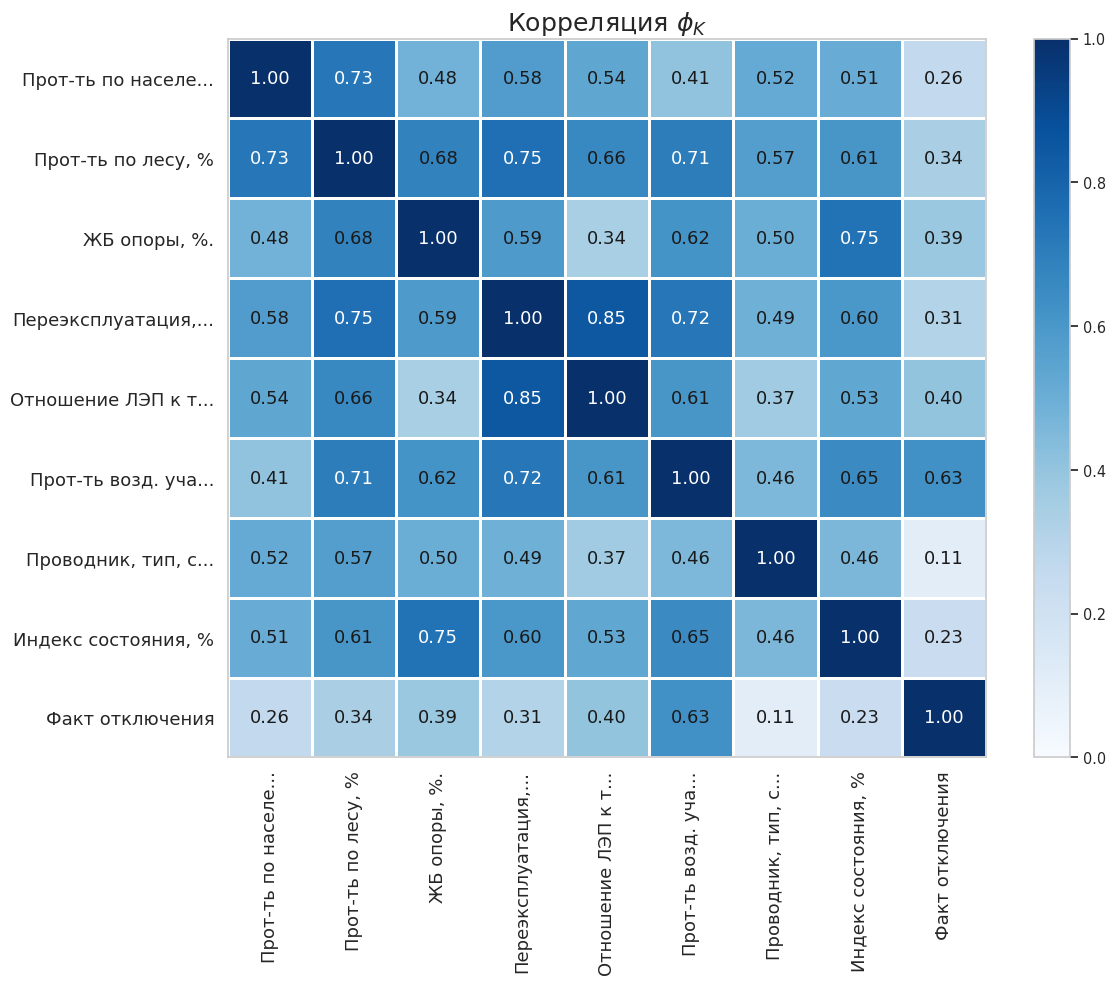

In [7]:
phik_overview = ML_df_110.phik_matrix(interval_cols=['Индекс состояния, %',
                                                     'Протяженность воздушных участков, км',
                                                     'ЖБ Опоры, %',
                                                     'Металлические опоры, %',
                                                     'Протяженность по лесу, %',
                                                     'Протяженность по населенной местности, %',
                                                     'Переэксплуатация, бр.'
                                                     ])


# Редактирование названия признаков для более наглядного отображения на тепловой карте
phik_overview.columns = ['Факт отключения',
                         'Индекс состояния, %',
                         'Проводник, тип, сечение',
                         'Прот-ть возд. участков, км',
                         'Отношение ЛЭП к транзиту',
                         'Переэксплуатация, бр.',
                         'ЖБ опоры, %.',
                         'Прот-ть по лесу, %',
                         'Прот-ть по населенной местности, %']

phik_overview.index = ['Факт отключения',
                       'Индекс состояния, %',
                       'Проводник, тип, сечение',
                       'Прот-ть возд. участков, км',
                       'Отношение ЛЭП к транзиту',
                       'Переэксплуатация, бр.',
                       'ЖБ опоры, %.',
                       'Прот-ть по лесу, %',
                       'Прот-ть по населенной местности, %']

# Построение тепловой карты
plot_correlation_matrix(phik_overview.values, x_labels=phik_overview.columns, y_labels=phik_overview.index,
                        vmin=0, vmax=1, color_map='Blues', title=r'Корреляция $\phi_K$', fontsize_factor=1.3,
                        figsize=(12,10))
plt.tight_layout()

Корреляционный анализ показал, что:

-	Замена абсолютных значений количества железнобетонных и металличе-ских опор, а также протяженностями по лесу и по населенной местности на относи-тельные величины позволило справиться с проблемой мультиколлеарности этих признаков, что должно благотворно повлиять на обучение ML моделей;
  
-	Целевой признак «Факт отключения» имеет не сильную, но достаточную корреляционную зависимость с рассматриваемыми переменными. Самую большую корреляцию показывает признак «Протяженность воздушных участков, км» (0,63), наименьшую - категориальный признак «Проводник, тип, сечение» (0,11);
  
-	Выявлена достаточно сильная корреляция (0,85) между сроком эксплуа-тации линии электропередачи и фактом, является ли ЛЭП транзитной или нет. Данный вопрос обсужден на предыдущем этапе по подготовки данных к машинному обучению [], в котором сделан вывод, что транзитные ЛЭП по представ-ленной статистике имеют больший срок эксплуатации, чем не транзитные ЛЭП.  Также решено оставить оба признака, так как эти параметры отражают абсолютно разные значения.


## Разбиение датасета на обучающую и тестовую выборки

Определим в качестве целоевого признака столбец 'Факт отключения':

In [8]:
target = ML_df_110['Факт отключения']
target = target.replace(['Нет', 'Да'], [0, 1])
features = ML_df_110.drop(['Факт отключения'], axis=1)

In [9]:
target.value_counts()

Факт отключения
0    232
1    163
Name: count, dtype: int64

Разделим признаки на обучающие и тестовые выборки в соотношении 8 к 2:

In [10]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.2, random_state=12345, stratify=target, shuffle = True)

print('"features_train":', features_train.shape[0],'объектов,',
      100 - round((features.shape[0] - features_train.shape[0]) * 100 / features.shape[0]), "%" )
print('"target_train":', target_train.shape[0],'объектов,',
      100 - round((target.shape[0] - target_train.shape[0]) * 100 / target.shape[0]), "%" )
print('"features_test":', features_test.shape[0],'объектов,',
      100 - round((features.shape[0] - features_test.shape[0]) * 100 / features.shape[0]), "%" )
print('"target_test":', target_test.shape[0],'объектов,',
      100 - round((target.shape[0] - target_test.shape[0]) * 100 / target.shape[0]), "%" )

"features_train": 316 объектов, 80 %
"target_train": 316 объектов, 80 %
"features_test": 79 объектов, 20 %
"target_test": 79 объектов, 20 %


## Кодирование и масштабирование признаков

Определим числовые и категориальные признаки:

In [11]:
numerical = features.select_dtypes(include=[np.number]).columns.tolist()
print('Числовые признаки:', numerical)
print()
categorical = features.select_dtypes(include='object').columns.tolist()
print('Категориальные признаки:', categorical)

Числовые признаки: ['Индекс состояния, %', 'Протяженность воздушных участков, км', 'Переэксплуатация, бр.', 'ЖБ Опоры, %', 'Протяженность по лесу, %', 'Протяженность по населенной местности, %']

Категориальные признаки: ['Проводник, тип, сечение', 'Отношение ЛЭП к транзиту']


Посмотрим на кардинальность категориальных признаков:

In [12]:
for i in categorical:
    print(i,':', features[i].unique())

Проводник, тип, сечение : ['АС-95' 'АС-120' 'АС-185' 'АС-150']
Отношение ЛЭП к транзиту : ['Транзитная' 'Не транзитная']


Так как кардинальность признаков низкая рекмондуется использовать OneHotEncoder. Составим Pipiline для кодирования и масштабирования признаков:

In [13]:
numerical_transformer = StandardScaler()
categorical_transformer_ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
categorical_transformer_ord_encoder = OrdinalEncoder()

# Делаем ColumnTransformer для категориальных переменных с ohe
preprocessor_ohe = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical),
        ('cat', categorical_transformer_ohe, categorical)], verbose_feature_names_out=True)


# Создадим класс для метода синтетической избыточной выборки меньшинства для номинального и непрерывного значений (SMOTE)
smote = SMOTENC(random_state=12345, categorical_features=[1, 3])

Подсчет уникальных значений показывает, что класс-меньшинство в 1,5 раза меньше класса-большинства, поэтому имеется смысл применить техники борьбы с дисбалансом. Для все моделей будем использовать параметр "взвешивания классов", а для одной из лучших попробуем технику создания синтетических объектов SMOTE для сравнения полученной метрики.

## Выбор и обучение моделей машинного обучения на кросс-валидации

Для обучения выбрем следующие модели:

- Support Vector Machine
- LogisticRegression,
- RandomForestClassifier,
- LightGBM Classifier,
- CatBoostClassifier.

Обучение и оценка моделей будет производится через перекрестную проверку с использованием 3 блоков для кросс-валидации.

### Support Vector Machine

In [14]:
%%time
#  Составляем pipeline:

pipeline_SVC = Pipeline([
    ('preprocessor_ohe', preprocessor_ohe),
    ('model_SVC', SVC(random_state=12345,
                     class_weight='balanced'))
])

param_grid = {'model_SVC__kernel': ['poly', 'rbf', 'sigmoid'],
              'model_SVC__C': np.arange(0,10,0.5),
              'model_SVC__gamma': np.arange(0,1,0.01)
             }

tuning_model_SVC = RandomizedSearchCV(pipeline_SVC,
                                      param_grid,
                                      cv=3,
                                      n_jobs=-1,
                                      scoring=['roc_auc', 'accuracy', 'recall', 'precision', 'f1', 'average_precision'],
                                      refit='roc_auc',
                                      verbose=0,
                                      n_iter=100,
                                      random_state=140823,
                                     )

tuning_model_SVC.fit(features_train, target_train)

print(f"Наилучшая метрика 'roc_auc', равная {round(tuning_model_SVC.best_score_,2)},\
достигается при параметрах: {tuning_model_SVC.best_params_}")

Наилучшая метрика 'roc_auc', равная 0.77,достигается при параметрах: {'model_SVC__kernel': 'rbf', 'model_SVC__gamma': 0.04, 'model_SVC__C': 9.0}
CPU times: user 775 ms, sys: 48 ms, total: 823 ms
Wall time: 12 s


### Support Vector Machine with SMOTE

In [15]:
%%time

#  Составляем pipeline:

pipeline_SVC_smote = Pipeline_smote([
    ("smote", smote),
    ("preprocessor_ohe", preprocessor_ohe),
    ('model_SVC', SVC(random_state=12345))
])


param_grid = {'model_SVC__kernel': ['poly', 'rbf', 'sigmoid'],
              'model_SVC__C': np.arange(0,10,0.5),
              'model_SVC__gamma': np.arange(0,1,0.01)
             }

tuning_model_SVC_smote = RandomizedSearchCV(pipeline_SVC_smote,
                                      param_grid,
                                      cv=3,
                                      n_jobs=-1,
                                      scoring=['roc_auc', 'accuracy', 'recall', 'precision', 'f1', 'average_precision'],
                                      refit='roc_auc',
                                      verbose=0,
                                      n_iter=100,
                                      random_state=140823,
                                     )

tuning_model_SVC_smote.fit(features_train, target_train)

print(f"Наилучшая метрика 'roc_auc', равная {round(tuning_model_SVC_smote.best_score_,2)},\
достигается при параметрах: {tuning_model_SVC_smote.best_params_}")

Наилучшая метрика 'roc_auc', равная 0.76,достигается при параметрах: {'model_SVC__kernel': 'sigmoid', 'model_SVC__gamma': 0.03, 'model_SVC__C': 6.0}
CPU times: user 1.27 s, sys: 125 ms, total: 1.4 s
Wall time: 17.6 s


### LogisticRegression

In [16]:
%%time

#  Составляем pipeline:

pipeline_LR = Pipeline([
    ('preprocessor_ohe', preprocessor_ohe),
    ('model_LR', LogisticRegression(random_state=12345,
                                    penalty='elasticnet',
                                    solver='saga',
                                    class_weight='balanced'))
])

param_grid = {'model_LR__C': np.arange(0, 5, 0.1),
              'model_LR__l1_ratio': np.arange(0, 1, 0.1)}


tuning_model_LR = RandomizedSearchCV(pipeline_LR,
                                      param_grid,
                                      cv=3,
                                      n_jobs=-1,
                                      scoring=['roc_auc', 'accuracy', 'recall', 'precision', 'f1', 'average_precision'],
                                      refit='roc_auc',
                                      verbose=0,
                                      n_iter=100,
                                      random_state=140823,
                                     )

tuning_model_LR.fit(features_train, target_train)

print(f"Наилучшая метрика 'roc_auc', равная {round(tuning_model_LR.best_score_,2)},\
достигается при параметрах: {tuning_model_LR.best_params_}")

Наилучшая метрика 'roc_auc', равная 0.78,достигается при параметрах: {'model_LR__l1_ratio': 0.9, 'model_LR__C': 0.6000000000000001}
CPU times: user 772 ms, sys: 60.3 ms, total: 833 ms
Wall time: 12.3 s


### LogisticRegression with SMOTE

In [17]:
%%time

#  Составляем pipeline:
pipeline_LR_smote = Pipeline_smote([
    ("smote", smote),
    ("preprocessor_ohe", preprocessor_ohe),
    ('model_LR', LogisticRegression(random_state=12345,
                                    penalty='elasticnet',
                                    solver='saga'))
])


param_grid = {'model_LR__C': np.arange(0, 5, 0.1),
              'model_LR__l1_ratio': np.arange(0, 1, 0.1)}


tuning_model_LR_smote = RandomizedSearchCV(pipeline_LR_smote,
                                      param_grid,
                                      cv=3,
                                      n_jobs=-1,
                                      scoring=['roc_auc', 'accuracy', 'recall', 'precision', 'f1', 'average_precision'],
                                      refit='roc_auc',
                                      verbose=0,
                                      n_iter=100,
                                      random_state=140823,
                                     )

tuning_model_LR_smote.fit(features_train, target_train)

print(f"Наилучшая метрика 'roc_auc', равная {round(tuning_model_LR_smote.best_score_,2)},\
достигается при параметрах: {tuning_model_LR_smote.best_params_}")

Наилучшая метрика 'roc_auc', равная 0.78,достигается при параметрах: {'model_LR__l1_ratio': 0.9, 'model_LR__C': 0.6000000000000001}
CPU times: user 1.43 s, sys: 104 ms, total: 1.53 s
Wall time: 36.4 s


### RandomForestClassifier

In [18]:
%%time

#  Составляем pipeline:

pipeline_RFC = Pipeline([
    ("preprocessor_ohe", preprocessor_ohe),
    ('model_RFC', RandomForestClassifier(random_state=123456,
                                         class_weight='balanced'))
])

param_grid = {
    'model_RFC__n_estimators': range (100, 1000, 100),
    'model_RFC__max_depth': range (1,21, 1),
    'model_RFC__min_samples_leaf': range (2,50,10),
    'model_RFC__min_samples_split': range (2,50,10),
    'model_RFC__criterion': ['gini', 'entropy', 'log_loss']
}

tuning_model_RFC = RandomizedSearchCV(pipeline_RFC,
                                      param_grid,
                                      cv=3,
                                      n_jobs=-1,
                                      scoring=['roc_auc', 'accuracy', 'recall', 'precision', 'f1', 'average_precision'],
                                      refit='roc_auc',
                                      verbose=0,
                                      n_iter=100,
                                      random_state=12345,
                                     )


tuning_model_RFC.fit(features_train, target_train)

print(f"Наилучшая метрика 'roc_auc', равная {round(tuning_model_RFC.best_score_,2)},\
достигается при параметрах: {tuning_model_RFC.best_params_}")

Наилучшая метрика 'roc_auc', равная 0.77,достигается при параметрах: {'model_RFC__n_estimators': 300, 'model_RFC__min_samples_split': 12, 'model_RFC__min_samples_leaf': 32, 'model_RFC__max_depth': 12, 'model_RFC__criterion': 'log_loss'}
CPU times: user 4.97 s, sys: 799 ms, total: 5.77 s
Wall time: 4min 59s


### RandomForestClassifier with SMOTE

In [19]:
%%time

#  Составляем pipeline:

pipeline_RFC_smote = Pipeline_smote([
    ("smote", smote),
    ("preprocessor_ohe", preprocessor_ohe),
    ('model_RFC', RandomForestClassifier(random_state=123456))
])


param_grid = {
    'model_RFC__n_estimators': range (100, 1000, 100),
    'model_RFC__max_depth': range (1,21, 21),
    'model_RFC__min_samples_leaf': range (2,50,10),
    'model_RFC__min_samples_split': range (2,50,10)}

tuning_model_RFC_smote = RandomizedSearchCV(pipeline_RFC_smote,
                                      param_grid,
                                      cv=3,
                                      n_jobs=-1,
                                      scoring=['roc_auc', 'accuracy', 'recall', 'precision', 'f1', 'average_precision'],
                                      refit='roc_auc',
                                      verbose=0,
                                      n_iter=100,
                                      random_state=12345,
                                     )


tuning_model_RFC_smote.fit(features_train, target_train)

print(f"Наилучшая метрика 'roc_auc', равная {round(tuning_model_RFC_smote.best_score_,2)},\
достигается при параметрах: {tuning_model_RFC_smote.best_params_}")

Наилучшая метрика 'roc_auc', равная 0.76,достигается при параметрах: {'model_RFC__n_estimators': 100, 'model_RFC__min_samples_split': 32, 'model_RFC__min_samples_leaf': 22, 'model_RFC__max_depth': 1}
CPU times: user 5.87 s, sys: 974 ms, total: 6.84 s
Wall time: 6min 30s


### LGBMClassifier

In [20]:
%%time

pipeline_LGBM = Pipeline([
    ("preprocessor_ohe", preprocessor_ohe),
    ('model_LGBM', LGBMClassifier(random_state=12345,
                                  class_weight='balanced'))
])

param_grid = {'model_LGBM__learning_rate': [0.0001, 0.001, 0.01],
              'model_LGBM__max_depth': np.arange(1, 21, 1),
              'model_LGBM__n_estimators': range (10, 1000, 10),
              'model_LGBM__num_leaves': range (2,50,1),
              'model_LGBM__boosting_type': ['gbdt', 'dart', 'goss'],
              'model_LGBM__reg_alpha': np.arange(0, 1, 0.1),
              'model_LGBM__reg_lambda': np.arange(0, 1, 0.1)
             }


tuning_model_LGBM = RandomizedSearchCV(pipeline_LGBM,
                                      param_grid,
                                      cv=3,
                                      n_jobs=-1,
                                      scoring=['roc_auc', 'accuracy', 'recall', 'precision', 'f1', 'average_precision'],
                                      refit='roc_auc',
                                      verbose=0,
                                      n_iter=100,
                                      random_state=12345
                                     )


tuning_model_LGBM.fit(features_train, target_train)

print(f"Наилучшая метрика 'roc_auc', равная {round(tuning_model_LGBM.best_score_,2)},\
достигается при параметрах: {tuning_model_LGBM.best_params_}")

[LightGBM] [Info] Number of positive: 130, number of negative: 186
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000085 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 295
[LightGBM] [Info] Number of data points in the train set: 316, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Наилучшая метрика 'roc_auc', равная 0.77,достигается при параметрах: {'model_LGBM__reg_lambda': 0.2, 'model_LGBM__reg_alpha': 0.6000000000000001, 'model_LGBM__num_leaves': 31, 'model_LGBM__n_estimators': 490, 'model_LGBM__max_depth': 1, 'model_LGBM__learning_rate': 0.01, 'model_LGBM__boosting_type': 'gbdt'}
CPU times: user 2.07 s, sys: 155 ms, total: 2.23 s
Wall time: 56.3 s


### LGBMClassifier with SMOTE

In [21]:
%%time

pipeline_LGBM_smote = Pipeline_smote([
    ("smote", smote),
    ("preprocessor_ohe", preprocessor_ohe),
    ('model_LGBM', LGBMClassifier(random_state=12345))
])


param_grid = {'model_LGBM__learning_rate': [0.0001, 0.001, 0.01],
              'model_LGBM__max_depth': np.arange(1, 21, 1),
              'model_LGBM__n_estimators': range (10, 1000, 5),
              'model_LGBM__num_leaves': range (2,50,1),
              'model_LGBM__boosting_type': ['gbdt', 'dart', 'goss'],
              'model_LGBM__reg_alpha': np.arange(0, 1, 0.1),
              'model_LGBM__reg_lambda': np.arange(0, 1, 0.1)
             }


tuning_model_LGBM_smote = RandomizedSearchCV(pipeline_LGBM_smote,
                                      param_grid,
                                      cv=3,
                                      n_jobs=-1,
                                      scoring=['roc_auc', 'accuracy', 'recall', 'precision', 'f1', 'average_precision'],
                                      refit='roc_auc',
                                      verbose=0,
                                      n_iter=100,
                                      random_state=12345
                                     )


tuning_model_LGBM_smote.fit(features_train, target_train)

print(f"Наилучшая метрика 'roc_auc', равная {round(tuning_model_LGBM_smote.best_score_,2)},\
достигается при параметрах: {tuning_model_LGBM_smote.best_params_}")

[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 186, number of negative: 186
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000062 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 317
[LightGBM] [Info] Number of data points in the train set: 372, number of used features: 11
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

### CatBoostClassifier

In [22]:
%%time

classes = np.unique(target)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=target)
class_weights = dict(zip(classes, weights))

pipeline_CBС = Pipeline([
    ("preprocessor_ohe", preprocessor_ohe),
    ('model_CBC', CatBoostClassifier(random_state=12345, class_weights=class_weights))
])

param_grid = {
    'model_CBC__depth': np.arange(1, 10, 1),
    'model_CBC__learning_rate':  [0.0001, 0.001, 0.01],
    'model_CBC__iterations':  range(10, 1000, 10),
    'model_CBC__l2_leaf_reg': np.arange(1, 15, 1),
    'model_CBC__max_leaves': range(2,50,1)
}


tuning_model_CBС = RandomizedSearchCV(pipeline_CBС,
                                      param_grid,
                                      cv=5,
                                      n_jobs=-1,
                                      scoring=['roc_auc', 'accuracy', 'recall', 'precision', 'f1', 'average_precision'],
                                      refit='roc_auc',
                                      verbose=0,
                                      n_iter=100,
                                      random_state=12345
                                     )
tuning_model_CBС.fit(features_train, target_train)

print(f"Наилучшая метрика 'roc_auc', равная {round(tuning_model_CBС.best_score_,2)},\
достигается с взвешиванием классов при параметрах: {tuning_model_CBС.best_params_}")

0:	learn: 0.6928463	total: 48.3ms	remaining: 34.7s
1:	learn: 0.6925087	total: 49.7ms	remaining: 17.8s
2:	learn: 0.6922308	total: 50.6ms	remaining: 12.1s
3:	learn: 0.6919617	total: 51.6ms	remaining: 9.23s
4:	learn: 0.6916871	total: 52.5ms	remaining: 7.51s
5:	learn: 0.6913816	total: 53.4ms	remaining: 6.35s
6:	learn: 0.6910628	total: 54.3ms	remaining: 5.53s
7:	learn: 0.6907671	total: 55.2ms	remaining: 4.91s
8:	learn: 0.6904586	total: 56.2ms	remaining: 4.44s
9:	learn: 0.6901674	total: 57.1ms	remaining: 4.05s
10:	learn: 0.6899524	total: 58ms	remaining: 3.74s
11:	learn: 0.6896444	total: 58.9ms	remaining: 3.47s
12:	learn: 0.6893769	total: 59.5ms	remaining: 3.23s
13:	learn: 0.6890545	total: 60.1ms	remaining: 3.03s
14:	learn: 0.6886725	total: 61ms	remaining: 2.87s
15:	learn: 0.6883828	total: 61.8ms	remaining: 2.72s
16:	learn: 0.6880952	total: 62.7ms	remaining: 2.59s
17:	learn: 0.6878149	total: 63.5ms	remaining: 2.48s
18:	learn: 0.6874914	total: 64.4ms	remaining: 2.38s
19:	learn: 0.6871918	total

### CatBoostClassifier with SMOTE

In [23]:
%%time

pipeline_CBС_smote = Pipeline_smote([
    ("smote", smote),
    ("preprocessor_ohe", preprocessor_ohe),
    ('model_CBC', CatBoostClassifier(random_state=12345))
])

param_grid = {
    'model_CBC__depth': np.arange(1, 10, 1),
    'model_CBC__learning_rate':  [0.0001, 0.001, 0.01],
    'model_CBC__iterations':  range(10, 1000, 10),
    'model_CBC__l2_leaf_reg': np.arange(1, 15, 1),
    'model_CBC__max_leaves': range(2,50,1)
}

tuning_model_CBС_smote = RandomizedSearchCV(pipeline_CBС_smote,
                                            param_grid,
                                            cv=3,
                                            n_jobs=-1,
                                            scoring=['roc_auc', 'accuracy', 'recall', 'precision', 'f1', 'average_precision'],
                                            refit='roc_auc',
                                            verbose=0,
                                            n_iter=100,
                                            random_state=12345
                                           )

tuning_model_CBС_smote.fit(features_train, target_train)

print(f"Наилучшая метрика 'roc_auc', равная {round(tuning_model_CBС_smote.best_score_,2)},\
достигается со SMOTE при параметрах: {tuning_model_CBС_smote.best_params_}")

0:	learn: 0.6929124	total: 1.17ms	remaining: 842ms
1:	learn: 0.6925265	total: 2.65ms	remaining: 950ms
2:	learn: 0.6922368	total: 3.63ms	remaining: 869ms
3:	learn: 0.6918625	total: 4.55ms	remaining: 815ms
4:	learn: 0.6915849	total: 5.45ms	remaining: 780ms
5:	learn: 0.6912494	total: 6.34ms	remaining: 755ms
6:	learn: 0.6909025	total: 7.25ms	remaining: 739ms
7:	learn: 0.6905902	total: 8.16ms	remaining: 726ms
8:	learn: 0.6902620	total: 9.06ms	remaining: 716ms
9:	learn: 0.6899170	total: 9.98ms	remaining: 709ms
10:	learn: 0.6897033	total: 10.9ms	remaining: 701ms
11:	learn: 0.6893627	total: 11.8ms	remaining: 695ms
12:	learn: 0.6889831	total: 12.7ms	remaining: 690ms
13:	learn: 0.6886134	total: 13.6ms	remaining: 685ms
14:	learn: 0.6883271	total: 14.5ms	remaining: 682ms
15:	learn: 0.6880129	total: 15.7ms	remaining: 691ms
16:	learn: 0.6877299	total: 17.2ms	remaining: 712ms
17:	learn: 0.6873954	total: 18.5ms	remaining: 720ms
18:	learn: 0.6870755	total: 19.4ms	remaining: 717ms
19:	learn: 0.6867998	t

### Dummy Model (Проверка на адекватность)

Проверим модели на адекватность путем сравнения полученнных значений метрик с контрольными константной модели DummyClassifier со стратегией классфикации “uniform”, генерирующей предсказания случайным образом c равной вероятностью для каждого класса.

In [24]:
%%time

pipeline_Dummy = Pipeline([
    ("preprocessor_ohe", preprocessor_ohe),
    ('model_dummy', DummyClassifier(strategy='uniform'))
])

param_grid = {}

model_Dummy = RandomizedSearchCV(pipeline_Dummy,
                                      param_grid,
                                      cv=3,
                                      n_jobs=-1,
                                      scoring=['roc_auc', 'accuracy', 'recall', 'precision', 'f1', 'average_precision'],
                                      refit='roc_auc',
                                      verbose=0,
                                      n_iter=100,
                                      random_state=12345
                                     )
model_Dummy.fit(features_train, target_train)

print(f"Наилучшая метрика 'roc_auc' равна {round(model_Dummy.best_score_,2)}")

Наилучшая метрика 'roc_auc' равна 0.5
CPU times: user 30.1 ms, sys: 906 µs, total: 31 ms
Wall time: 104 ms


## Выбор лучшей модели по метрике ROC-AUC на кросс-валидации

In [25]:
model_names = ["Support Vector Machine", "Support Vector Machine  with SMOTE", "Logistic Regression",
               "Logistic Regression with SMOTE", "Random Forest Classifier", "Random Forest Classifier with SMOTE",
               "LightGBM Classifier", "LightGBM Classifier with SMOTE", "CatBoost Classifier",
               "CatBoost Classifier with SMOTE", "Dummy Model" ]

models = [tuning_model_SVC,tuning_model_SVC_smote,
          tuning_model_LR, tuning_model_LR_smote,
          tuning_model_RFC, tuning_model_RFC_smote,
          tuning_model_LGBM, tuning_model_LGBM_smote,
          tuning_model_CBС, tuning_model_CBС_smote,
          model_Dummy]

model_comparison= pd.DataFrame(columns=["модель","ROC-AUC", 'AUC-PR', 'Accuracy', 'Recall', 'Precision', 'F1'])

for i in range(len(models)):
    model_comparison.loc[i,:] = [model_names[i],
                                 round(models[i].cv_results_['mean_test_roc_auc'][models[i].best_index_],3),
                                 round(models[i].cv_results_['mean_test_average_precision'][models[i].best_index_],3),
                                 round(models[i].cv_results_['mean_test_accuracy'][models[i].best_index_],3),
                                 round(models[i].cv_results_['mean_test_recall'][models[i].best_index_],3),
                                 round(models[i].cv_results_['mean_test_precision'][models[i].best_index_],3),
                                 round(models[i].cv_results_['mean_test_f1'][models[i].best_index_],3),
                                ]

model_comparison = model_comparison.set_index('модель')
model_comparison = model_comparison.sort_values(by="ROC-AUC", ascending = False)
#model_comparison.to_excel('model_comparison.xlsx')
model_comparison

,ROC-AUC,AUC-PR,Accuracy,Recall,Precision,F1
модель,,,,,,
Logistic Regression,0.78,0.68,0.699,0.708,0.618,0.66
Logistic Regression with SMOTE,0.778,0.679,0.69,0.67,0.613,0.638
CatBoost Classifier,0.776,0.655,0.693,0.708,0.618,0.657
Random Forest Classifier,0.772,0.661,0.687,0.693,0.607,0.644
LightGBM Classifier with SMOTE,0.772,0.652,0.69,0.686,0.609,0.642
LightGBM Classifier,0.771,0.647,0.715,0.762,0.631,0.687
CatBoost Classifier with SMOTE,0.771,0.64,0.712,0.692,0.641,0.664
Support Vector Machine,0.768,0.672,0.687,0.685,0.606,0.642
Support Vector Machine with SMOTE,0.761,0.671,0.687,0.67,0.61,0.637


In [26]:
best_model_params= pd.DataFrame(columns=["модель","Параметры"])

for i in range(len(models)):
    best_model_params.loc[i,:] = [model_names[i],
                                 models[i].best_params_]


best_model_params = best_model_params.set_index('модель')

#best_model_params.to_excel('best_model_params.xlsx')
display(HTML(best_model_params.to_html()))

,Параметры
модель,
Support Vector Machine,"{'model_SVC__kernel': 'rbf', 'model_SVC__gamma': 0.04, 'model_SVC__C': 9.0}"
Support Vector Machine with SMOTE,"{'model_SVC__kernel': 'sigmoid', 'model_SVC__gamma': 0.03, 'model_SVC__C': 6.0}"
Logistic Regression,"{'model_LR__l1_ratio': 0.9, 'model_LR__C': 0.6000000000000001}"
Logistic Regression with SMOTE,"{'model_LR__l1_ratio': 0.9, 'model_LR__C': 0.6000000000000001}"
Random Forest Classifier,"{'model_RFC__n_estimators': 300, 'model_RFC__min_samples_split': 12, 'model_RFC__min_samples_leaf': 32, 'model_RFC__max_depth': 12, 'model_RFC__criterion': 'log_loss'}"
Random Forest Classifier with SMOTE,"{'model_RFC__n_estimators': 100, 'model_RFC__min_samples_split': 32, 'model_RFC__min_samples_leaf': 22, 'model_RFC__max_depth': 1}"
LightGBM Classifier,"{'model_LGBM__reg_lambda': 0.2, 'model_LGBM__reg_alpha': 0.6000000000000001, 'model_LGBM__num_leaves': 31, 'model_LGBM__n_estimators': 490, 'model_LGBM__max_depth': 1, 'model_LGBM__learning_rate': 0.01, 'model_LGBM__boosting_type': 'gbdt'}"
LightGBM Classifier with SMOTE,"{'model_LGBM__reg_lambda': 0.7000000000000001, 'model_LGBM__reg_alpha': 0.9, 'model_LGBM__num_leaves': 47, 'model_LGBM__n_estimators': 865, 'model_LGBM__max_depth': 15, 'model_LGBM__learning_rate': 0.001, 'model_LGBM__boosting_type': 'goss'}"
CatBoost Classifier,"{'model_CBC__max_leaves': 16, 'model_CBC__learning_rate': 0.001, 'model_CBC__l2_leaf_reg': 14, 'model_CBC__iterations': 720, 'model_CBC__depth': 4}"


Согласно таблице 2, все обученные ML модели показали результаты на порядок выше предсказаний константной модели. Наилучшим методом борьбы с несбалан-сированной выборкой оказался метод взвешивая классов. По метрике ROC AUC луч-шей моделью выбрана логистическая регрессия с методом взвешивания классов в ка-честве борьбы с дисбалансом классов (0,78), что выражается в простоте самой модели и хорошей аппроксимации. Данная модель показала также лучшие результаты по метрике AUC-PR (0,68), что указывает на успешное прогнозирование целевого при-знака в условиях несбалансированной выборки.

In [27]:
best_model = tuning_model_LR.best_estimator_

# Оценка качества модели на тестовой выборке

In [28]:
predictions = best_model.predict(features_test)
probabilities_test = best_model.predict_proba(features_test)

print('Метрики наилучшей модели на тесовой выборке:')
print('Метрика ROC-AUC:', round(roc_auc_score(target_test,probabilities_test[:, 1], average=None),3))
print('Метрика Accuracy:', round(accuracy_score(target_test, predictions),3))

Метрики наилучшей модели на тесовой выборке:
Метрика ROC-AUC: 0.835
Метрика Accuracy: 0.759


Модель показала отличные результаты -ROC AUC со значением в 0.84. Значение метрики оказалось выше, чем на валидационной выборке, что указывает на отсут-ствие переобучения модели, однако, большие расхождения между метриками на разных выборках сигнализирует о проблеме недостаточного количества данных (в те-стовой выборке было всего 79 объектов).

## Матрица ошибок

Наглядно представить результаты вычислений метрик точности и полноты позволяет матрица ошибок. Матрица ошибок формируется следующим образом: по диагонали от верхнего левого угла выстроены правильные прогнозы, вне главной диагонали — ошибочные варианты и содержит:
- Истинно отрицательные ответы (True Negative) в левом верхнем углу,
- Истинно положительные ответы (True Positive) в правом нижнем углу,
- Ложноположительные ответы (False Positive) в правом верхнем углу,
- Ложноотрицательные ответы (False Negative) в левом нижнем углу.

In [29]:
cm = confusion_matrix(target_test,predictions)
cm

array([[38,  8],
       [11, 22]])

Визуализируем матрицу ошибок:

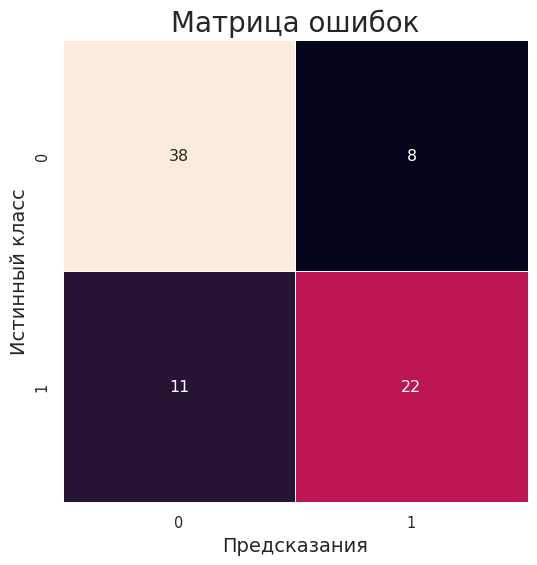

In [30]:
plt.figure(figsize=(6, 6))

sns.heatmap(cm, annot=True, linewidth=.5, fmt=".0f", cbar=False, linecolor='white')
plt.title("Матрица ошибок", fontsize=20)
plt.xlabel('Предсказания', fontsize=14)
plt.ylabel('Истинный класс', fontsize=14)
plt.show()

Цель задачи состоит в максимизации истинно положительных и истинно отрицательных ответов и минимизации ложноположительных и ложноотрицательных ответов. Лучшая модель CatBoostClassifier выдает 38 истинно положительных и 22 истинно отрицательных ответов, при этом на долю ложных приходится 8 положительных и 11 отрицательных ответов соответственно.

## ROC-AUC и ROC-кривая

Проверим лучшую модель (CatBoostClassifier) на тестовой выборке:

Построим ROC-кривую для лучшей модели и изобразите её на графике:

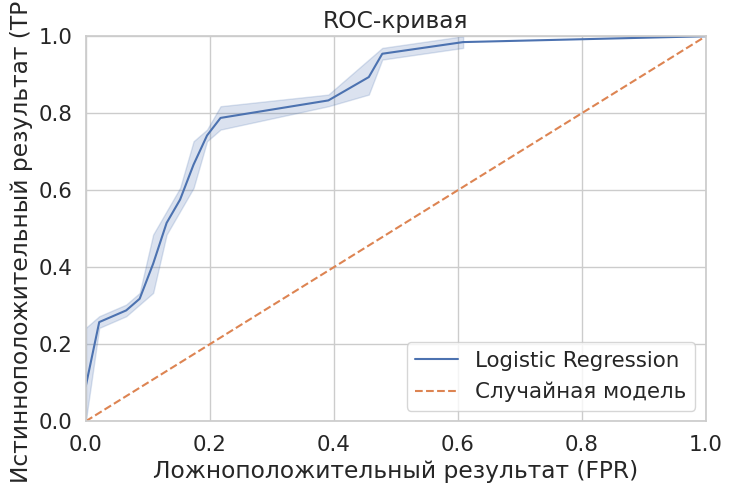

In [31]:
# Определим долю ложноположительных ответов (FPR) и истинно положительных ответов (TPR) лучшей модели:
probabilities = best_model.predict_proba(features_test)

fpr, tpr, thresholds = roc_curve(target_test, probabilities[:, 1])

# ROC-кривая лучшей модели:
sns.set_theme(context='notebook', style='whitegrid', palette='deep', font='sans-serif', font_scale=1.4, color_codes=True, rc=None)
plt.figure(figsize=(8, 5))
sns.lineplot(x=fpr, y=tpr, label="Logistic Regression")

# ROC-кривая случайной модели:
sns.lineplot(x=[0, 1],
             y=[0, 1],
             linestyle='--',
             label="Случайная модель")\
.set(xlabel='Ложноположительный результат (FPR)',
     ylabel='Истинноположительный результат (TPR)',
     title = 'ROC-кривая')

plt.xlim(0,1)
plt.ylim(0,1)
plt.legend()
plt.show()

На графике по горизонтали показана доля ложноположительных ответов (False Positive Rate), по вертикали - доля истинно положительных ответов (True Positive Rate). Для модели, которая всегда отвечает случайно, ROC-кривая представлена прямой оранжевой пунктирной линией. Касательно качества модели на графике, если модель не делает ошибок, то кривая будет стремиться к точке (0.0,1.0), в противном случае, AUC-ROC стремиться к 0.5, то есть случайно выдавать вероятность классов. Полученная площадь под кривой метрика AUC-ROC в 0.84 Однако, следует принимать во внимание, имеется проблема малой выборки, которая наглядно видна на ROC кривой, имеющая резкие «переломы» из-за недостаточности данных.

Построим  PR-кривую на графике, где по вертикали наносится значение точности, по горизонтали — полноты.
Изобразим на графике, как выглядят значения метрик при изменении порога.
На графике по вертикали наносится значение точности, по горизонтали — полноты. Кривая, показывающая их значения, называетс (от англ. Precision и Recall). Чем выше кривая, тем лучше модель.

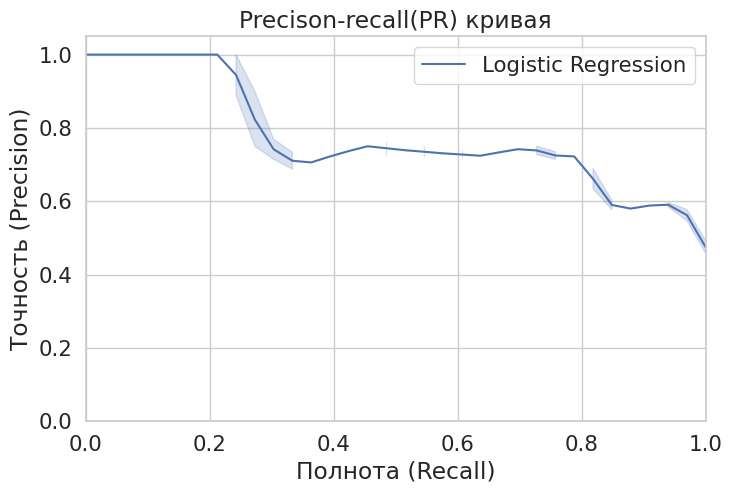

In [32]:
precision, recall, thresholds = precision_recall_curve(target_test, probabilities[:, 1])

plt.figure(figsize=(8, 5))
sns.lineplot(x=recall, y=precision, label="Logistic Regression")\
.set(xlabel='Полнота (Recall)',
     ylabel='Точность (Precision)',
     title = 'Precison-recall(PR) кривая')

plt.xlim(0,1)
plt.ylim(0,1.05)
plt.legend()
plt.show()

Несмотря на это, модель справляется с поставленной задачей, а графическое отображение ROC кривой позволяет утверждать, что при изменении порога классификации можно достичь высокого результата. Например, если необ-ходимо, чтобы в предсказание модели попадали все 100 % ЛЭП, на которых наблю-даются отказы (отсутствие ошибок I рода), то согласно графику ROC кривой, к этому классу будет отнесено до 60% ЛЭП, на которых отказов не наблюдалось (ошибки II рода). И наоборот, если нужна точность предсказаний для обоих классов, то можно вычислить, что при пороге классификации приблизительно в 0,4 истин-но-положительные предсказания TPR равны 0,8, тогда как ложноположительные предсказания составят всего лишь 0,2. На PR кривой видно, что точность (Preсion) стабилизируется на значении 0,72…0,75 при полноте (Recall) от 0,35 до 0,78 при соответствующих порогах классификации 0,45…0,58. Таким образом, знание рассмотренных выше метрик при определенных уровней порога классификации позволяет регулировать количество ошибок I и II рода.

#  Важность признаков

Рассмотрим важность признаков у модели CatBoostClassifier и оценочные коэффициенты LogisticRegression.

In [33]:
tuning_model_LR.best_estimator_

Pipeline(steps=[('preprocessor_ohe',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Индекс состояния, %',
                                                   'Протяженность воздушных '
                                                   'участков, км',
                                                   'Переэксплуатация, бр.',
                                                   'ЖБ Опоры, %',
                                                   'Протяженность по лесу, %',
                                                   'Протяженность по '
                                                   'населенной местности, %']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['Проводник, тип, сечение',
                                                   'Отношение ЛЭП к '
                                                   'транзиту'])])),
                ('model_LR',
                 LogisticRegression(C=0.6000000000000001,
                                    class_weight='balanced', l1_ratio=0.9,
                                    penalty='elasticnet', random_state=12345,
                                    solver='saga'))])

In [34]:
feature_importance = [tuning_model_CBС.best_estimator_[0].transformers_[0][2] + tuning_model_CBС.best_estimator_[0].transformers_[1][1].get_feature_names_out(categorical).tolist(),
          list(tuning_model_CBС.best_estimator_[1].feature_importances_), list(tuning_model_LR.best_estimator_[1].coef_[0])]

feature_importance = pd.DataFrame(feature_importance).transpose()
feature_importance.columns =['Признаки', 'Важность_CBC','Коэффициенты_LR']

feature_importance = feature_importance.set_index('Признаки', drop=True).sort_values(by='Важность_CBC', ascending=False)
feature_importance

,Важность_CBC,Коэффициенты_LR
Признаки,,
"Протяженность воздушных участков, км",48.945462,0.858306
"ЖБ Опоры, %",15.526429,0.181246
Отношение ЛЭП к транзиту_Транзитная,9.991521,0.444649
Отношение ЛЭП к транзиту_Не транзитная,9.628587,-0.547588
"Индекс состояния, %",3.757181,-0.031693
"Переэксплуатация, бр.",3.31902,0.037255
"Протяженность по населенной местности, %",3.243971,-0.224091
"Протяженность по лесу, %",3.225941,0.0
"Проводник, тип, сечение_АС-185",1.184109,0.0


No charts were generated by quickchart


Визуализируем таблицу:

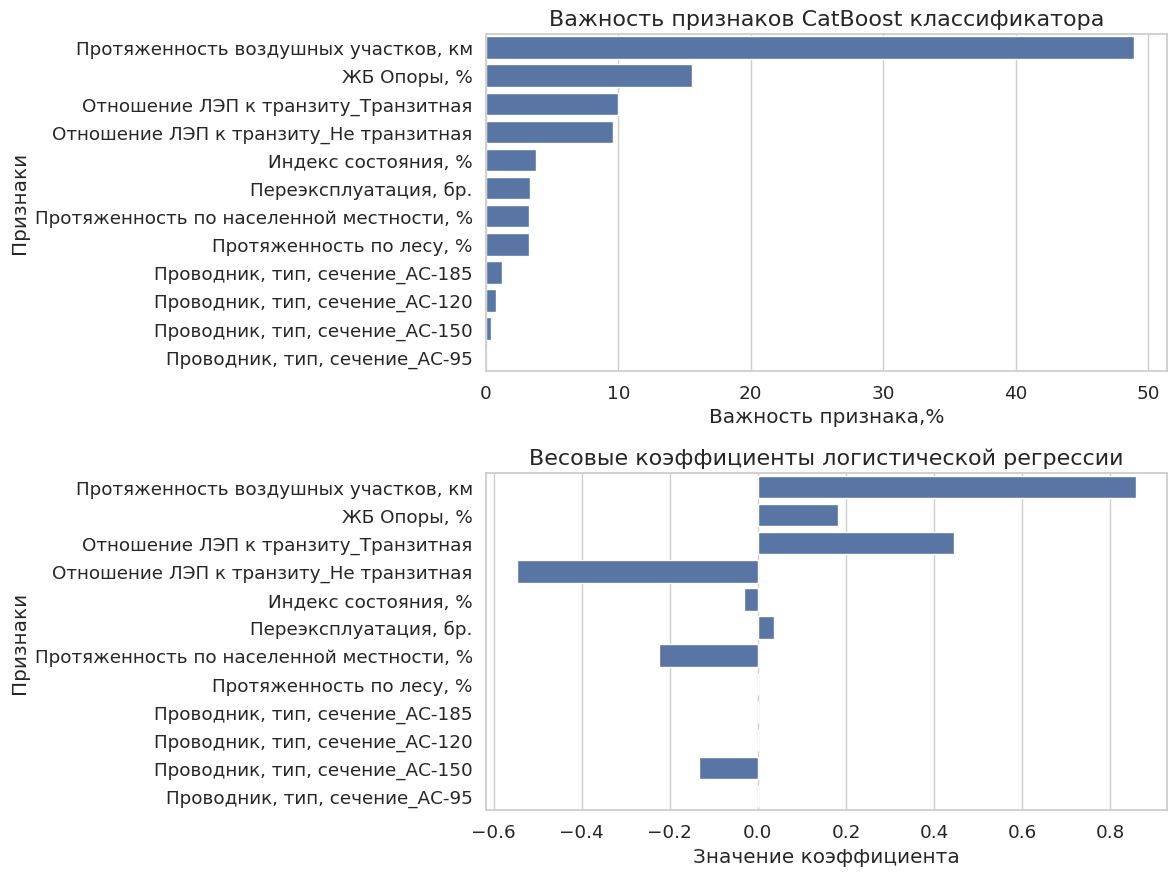

In [35]:
sns.set_theme(context='notebook', style='whitegrid', palette='deep', font='sans-serif', font_scale=1.2, color_codes=True, rc=None)


pic_box = plt.figure(figsize=(12,9))
pic_box.add_subplot(2,1,1)
sns.barplot(feature_importance, y = feature_importance.index, x = 'Важность_CBC')
plt.title('Важность признаков CatBoost классификатора', fontsize = 16)
plt.xlabel('Важность признака,%')


pic_box.add_subplot(2,1,2)
sns.barplot(feature_importance, y = feature_importance.index, x = 'Коэффициенты_LR')
plt.title('Весовые коэффициенты логистической регрессии', fontsize = 16)
plt.xlabel('Значение коэффициента')
plt.tight_layout()

Ожидаемо, наибольший вклад в прогнозирование обоих моделей вносит при-знак «Протяженность воздушных участков ЛЭП», при этом влияние этого признака на предсказание CatBoost классификатора достигает 48 %. Таким образом, еще раз подтверждается факт, что с увеличением протяженности ЛЭП увеличивается количе-ство отказов на ней, поэтому для оценки эффективности работы энергоснабжающих организаций часто используется параметр потока отказов - количество отказов на определенную длину ЛЭП.

Признаки, определяющие протяженность ЛЭП по населенной местности и лесу были переведены в относительные единицы от общей протяженности ЛЭП, поэтому их влияние на результаты моделей оказались не такими существенными. Несмотря на это, интересным фактом является наличие обратной зависимости отказов ЛЭП от относительной протяжённости по населённой местности (весовой коэффициент признака LR равен -0,27 при важности у CatBoost классификатора в 3%), то есть чем больше протяженность ЛЭП по населенной местности, тем ниже вероятность отказов на ней. В свою очередь, протяжённость по лесу имеет важность у CatBoost классифи-катора в 3 % (Рисунок 1 б), а весовой коэффициент у LR модели всего лишь 0.02, что достаточно мало и говорит о том, что древесно-кустарниковая растительность хорошо расчищается в охранной зоне ЛЭП 110 кВ и их влияние на отказы не проявляется.

В предыдущем исследовании по EDA установлено, что количество опор явно коррелирует с протяженность ЛЭП, поэтому в этом исследовании использовался синтетический признак, отражающий относительное число ЖБ опор от всего числа опор (ЖБ плюс металлические). Выявлено, что большее содержание ЖБ опор относи-тельно металлических опор влечет за собой повышение вероятности отказов на ЛЭП. Так важность этого признака у CatBoost классификатора равна 15,5 %, весовой ко-эффициент логистической модели – 0,2.

Сильное влияние на вероятность отключений на ЛЭП 110 кВ дает факт транзит-ности линии. Данный признак является категориальным и в предложенном в данной работе алгоритме по подготовке данных этот признак был обработан методом горя-чего кодирования (One Hot Encoding), в результате которого образовались 2 признака: факт транзитности линии и факт не тразитности, причем оба признака влияют на предсказание CatBoost модели с важностью почти в 10 %. При этом весовые коэф-фициенты логистической регрессии также подтверждают сильное влияние этого признака на предсказание факта отключения электроэнергии на ЛЭП, причем факт транзитности имеет прямую зависимость с целевой переменной (весовой коэффи-циент равен 0,49), а факт не тразитности – обратную (весовой коэффициент равен -0,59).

Срок эксплуатации, который выражается через признак «Переэксплуатация», оказывает довольно слабое влияние на целевую переменную (важность признака равна 3,3 %, весовой коэффициент – 0,04), что говорит о том, что линии такого напряжения всегда стараются поддерживать в прекрасном состоянии и постоянно модернизируются.

Довольно неочевидно выделяется влияние индекса состояния ЛЭП на целевую переменную. Логически рассуждая, можно предположить, что чем хуже состояние линии, тем больше вероятность отказа этой линии. Однако, этот факт при анализе важности признаков не наблюдается - так важность этого признака для предсказа-ния CatBoost классификатора равна всего лишь 3,8 %, а весовой коэффициент LR мо-дели – минус 0,04. Такое слабое влияние может быть объяснено искусственным управлением данным параметром в отчетных документах электросетевых компаний в зависимости от необходимости проведения планово-предупредительных работ.

Рассматривая важность типа проводника ЛЭП на предсказание модели, необ-ходимо отметить, что весовые коэффициенты для проводников типа АС-185, АС-120, АС-95 равны нулю, что говорит об отсутствии их влияния на отказы ЛЭП. Однако, имеется достаточная отрицательная зависимость влияния проводника АС-150 на це-левую переменную (-0,24). Данный факт объясняется малой выборкой и случайной спецификой электрических сетей в Орловской области – проводники типа АС сече-нием 150 и 185 чаще являются транзитными (в процентном соотношении в 78% и 80% случаях, соответственно), в то время как проводники сечением 150 – только в 56% случаях.

# Выводы

В рамках данного исследования было предложено использование моделей ма-шинного обучения, а именно классификаторов SVM, LogisticRegression, RandomForestClassifier, LightGBM Classifier и CatBoostClassifier, для прогнозирова-ния отключений электрической энергии на линиях электропередачи 110 кВ на основе данных по параметрам самих линий. Данные для моделей предложено подготавли-вать методом горячего кодирования One-Hot Encoding для категориальных перемен-ных и методом стандартизацией данных Standard Scaler для количественных. Для ав-томатизации процесса преобразования данных и устранения возможности их утечки используется пайплайн (Pipeline) и компоновщик разнородных признаков Column Transformer. Настройка гиперпараметров классификаторов осуществлена методами оптимизации случайных параметров RandomizedSearchCV и сеточного поиска GridSearchCV.

По метрике ROC AUC лучшей моделью стала логистическая регрессия с методом взвешивания классов в качестве борьбы с дисбалансом классов, показавшая результат в 0,78, что выражается в простоте самой модели и хорошей аппроксимации. Данная модель показала также лучшие результаты по метрике AUC-PR (0,68), что указывает на успешное прогнозирование целевого признака даже в условиях несбалансиро-ванной выборки. На тестовой выборке логистическая регрессия также показала отличный результат - ROC AUC со значением в 0,84, что подтвердило отсутствие переобучения модели, но показало влияние проблемы недостаточного количества данных, выраженного в значительном превышении метрик на тестовой выборке в сравнении с валидационной.

Использование встроенных методов для оценки важности признаков для логи-стической регрессии и CatBoost классификатора позволило степень влияния пара-метров ЛЭП на факт отключения электрической энергии. Ожидаемо, наибольший вклад в прогнозирование обоих моделей вносит признак «Протяженность воздушных участков ЛЭП» (до 48 % у CatBoost классификатора достигает). Протяженность ЛЭП по населенной местности показывает наличие обратной зависимости с целевой переменной, то есть чем больше протяженность ЛЭП по населенной местности, тем ниже вероятность отказов на ней. В тоже самое время протяженность по лесу имеет довольно слабую корреляцию с фактом отказов. Касательно типов опор, выявлено, что большее содержание ЖБ опор относительно металлических опор влечет за собой повышение вероятности отказов на ЛЭП. Так важность этого признака у CatBoost классификатора равна 15,5 %, весовой коэффициент логистической модели – 0,2. Сильное влияние на вероятность отключений на ЛЭП 110 кВ дает факт транзитности линии - важность этого признака у CatBoost классификатора равна 10 %, причем факт транзитности имеет прямую зависимость с целевой переменной (весовой ко-эффициент логистической регрессии равен 0,49), а факт не тразитности – обратную (весовой коэффициент равен -0,59). Срок эксплуатации и состояния ЛЭП оказывают довольно слабое влияние на целевую переменную.

Результаты данного исследования показывают возможность прогнозирования отключений электрической энергии на линиях электропередачи 110 кВ на основе данных по параметрам самих линий, что видно из полученных метрик качества ML моделей. Однако, из-за ограниченного набора данных (395 объектов) не удалось достичь постоянного результата (наблюдаются значительные расхождения между метриками качества на тестовой и валидационной выборках), поэтому в рамках будущего исследования необходимо расширить набор данных за счет включения линий других регионов и/или анализа дополнительных периодов фиксации отказов на ЛЭП.  

%%capture
!pip install nbconvert
import nbconvert

%%capture
!jupyter nbconvert outages-2d_part.ipynb --to pdf --TemplateExporter.exclude_input=True